**Этап построения модели машинного обучения**

---
Стандартные шаги перед обучением (стандартизация/нормализаця), решение необходомости ресамплинга из-за дисбаланса данных, выбор параметров модели и бизнесс логика - ***ваше домашнее задание***

In [69]:
import pandas as pd
import numpy as np

from scipy import stats

from scipy.stats import mannwhitneyu, ttest_ind, kruskal, chisquare, pearsonr, spearmanr
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, \
recall_score, f1_score, log_loss, confusion_matrix, \
    classification_report, roc_curve, auc, precision_recall_curve

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [70]:
RAND = 7575

# Загрузка данных

In [71]:
df = pd.read_csv('final_ab_ds.csv')
df = df.dropna()

In [72]:
df.shape

(35680, 20)

In [73]:
df['pneumonia'].unique(), df['ah'].unique()

(array([1]), array([0]))

In [74]:
df['Unnamed: 0'].nunique()

35680

В признаке pneumonia и ah все объекты имеют одни и теже значения, т.е. они неинформативны. Не будем использовать эти признаки.

Признак 'person_id' - также неиформативен и признак 'Unnamed: 0' - вероятно является тоже неким id. Также не будем использовать эти признаки.

In [75]:
df.head(3)

,Unnamed: 0,person_id,procalcitonine,fibrinogen,creatinine,wbc,hb,plt,crp,esr,lymph,pneumonia,ihd,dm,ah,sex,len,age,GFR,ab_indication
1,3822,158,0.000000,8.909846,1.030282,1.363834,143.647123,644.437365,58.343027,34.424705,23.300684,1,0,0,0,1,17,56,60.894798,0
2,915492,342,0.000000,7.092240,1.027174,25.710224,130.864644,483.261016,0.800000,25.493102,27.004637,1,0,0,0,1,34,56,61.117621,0
3,641908,108,0.134918,13.265546,0.707201,0.410000,141.945473,477.671705,7.526411,46.599795,17.167563,1,0,0,0,1,26,56,95.972393,0


In [76]:
df['ihd'].unique()

array([0, 1])

4 признака, по факту, являются категориальными.

In [77]:
cat_feats = ['pneumonia', 'ihd', 'ah', 'sex']

In [78]:
df.drop(['pneumonia', 'ah', 'person_id', 'Unnamed: 0'], axis=1, inplace=True)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35680 entries, 1 to 54975
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   procalcitonine  35680 non-null  float64
 1   fibrinogen      35680 non-null  float64
 2   creatinine      35680 non-null  float64
 3   wbc             35680 non-null  float64
 4   hb              35680 non-null  float64
 5   plt             35680 non-null  float64
 6   crp             35680 non-null  float64
 7   esr             35680 non-null  float64
 8   lymph           35680 non-null  float64
 9   ihd             35680 non-null  int64  
 10  dm              35680 non-null  int64  
 11  sex             35680 non-null  int64  
 12  len             35680 non-null  int64  
 13  age             35680 non-null  int64  
 14  GFR             35680 non-null  float64
 15  ab_indication   35680 non-null  int64  
dtypes: float64(10), int64(6)
memory usage: 4.6 MB


In [80]:
# проверим остались ли пропуски
df.isna().any().any()

False

In [81]:
# проверим остались ли дубли
df.duplicated().any()

False

In [82]:
df.describe()

,procalcitonine,fibrinogen,creatinine,wbc,hb,plt,crp,esr,lymph,ihd,dm,sex,len,age,GFR,ab_indication
count,35680.000000,35680.000000,35680.000000,35680.000000,35680.000000,35680.000000,35680.000000,35680.000000,35680.000000,35680.000000,35680.000000,35680.000000,35680.000000,35680.000000,35680.000000,35680.000000
mean,0.223226,8.221106,0.955292,19.731314,136.316272,365.741457,40.642421,29.736816,15.657603,0.328447,0.000308,0.987276,30.434473,56.188957,68.432292,0.248683
std,0.191179,2.743891,0.129787,12.964722,13.388109,196.527352,33.695465,15.050353,8.843542,0.469655,0.017556,0.112083,10.279696,6.605270,12.240047,0.432256
min,0.000000,2.440000,0.667421,0.410000,85.000000,4.100000,0.800000,1.000000,0.010000,0.000000,0.000000,0.000000,5.000000,25.000000,39.080968,0.000000
25%,0.049837,6.313580,0.867231,9.561287,127.313756,222.130922,9.689840,18.935149,9.240164,0.000000,0.000000,1.000000,23.000000,56.000000,59.663348,0.000000
50%,0.177051,8.190892,0.955109,19.235831,136.285121,366.060121,36.645410,29.632108,15.460375,0.000000,0.000000,1.000000,30.000000,56.000000,66.624504,0.000000
75%,0.442477,10.098011,1.042678,28.682272,145.197873,505.474558,63.598027,40.336945,21.700623,1.000000,0.000000,1.000000,38.000000,60.000000,75.388802,0.000000
max,0.803586,18.000000,1.478885,81.016468,203.269651,894.000000,193.083517,63.000000,43.000000,1.000000,1.000000,1.000000,52.000000,84.000000,127.972879,1.000000


Категориальных признаков у нас нет.

In [83]:
df['ab_indication'].unique()

array([0, 1])

# EDA

**Бизнес задача и выбор метрики**

Пусть нашей задачей будет прогнозировать необходимость лечения антибиотиками. Мы стремимся уменьшить количество назначения курса антибиотика, т.е. назначать только тем, кому лечение определённо необходимо. Возможно тут следует использовать precision.

Но хочу использовать интегральную метрику roc-auc. Исхожу из предположения, что день лечения относительно дорог. И если мы не назначили антибиотики, и пациент вернулся, то это будут дополнительные расходы. (помимо важности своевременного лечения). Исходя из этой логики нам потребуются дополнительные пороги (в данном случае, т.к. размылял о длительности лечения в стационаре, т.е. нам бы необходимо знать стоимость 1 дня лечения, стоимость повторного лечения в случае ухудшения здоровья пациента из-за неназначения курса. Опять же всё это в принципе, помимо вообще степени тяжести заболевания пациента и проблем.).
Для этого всего нам необходимы другие данные.
Если исходить из качества лечения и здоровья пациентов, то необходимо знать какие побочные явления могут вызывать данные антибиотики, чтобы оценивать риски назначения лечения не тем пациентам.

В общем, выбрал roc-auc.



## Проверка на нормальность распределения.

In [84]:
columns =['plt', 'esr', 'fibrinogen', 'creatinine', 'wbc',  'crp','lymph']
df_no_ind = df[df['ab_indication'] == 0]
df_ind = df[df['ab_indication'] == 1]

In [85]:
for i in columns:
  lst1 = df_no_ind[i]
  lst2 = df_ind[i]
  shapiro_test = stats.shapiro(lst1) # тест шапиро-уилка
  shapiro_test2 = stats.shapiro(lst2) # тест шапиро-уилка
  if shapiro_test[1] < .05:
    print('Данные {0} распределены ненормально,\
           p-value - {1}'.format(i,  shapiro_test[1]))
  if shapiro_test2[1] < .05:
    print('Данные {0} распределены ненормально,\
           p-value - {1}'.format(i,  shapiro_test2[1]))
  else:
    pass

Данные plt распределены ненормально,           p-value - 1.7142533019814427e-20
Данные plt распределены ненормально,           p-value - 0.0
Данные esr распределены ненормально,           p-value - 1.1145927985239595e-40
Данные esr распределены ненормально,           p-value - 1.4016444175928051e-30
Данные fibrinogen распределены ненормально,           p-value - 9.587672119282562e-20
Данные fibrinogen распределены ненормально,           p-value - 4.379362085706425e-27
Данные creatinine распределены ненормально,           p-value - 1.95159155019103e-23
Данные creatinine распределены ненормально,           p-value - 3.3187122212667564e-13
Данные wbc распределены ненормально,           p-value - 0.0
Данные wbc распределены ненормально,           p-value - 9.937696198009841e-29
Данные crp распределены ненормально,           p-value - 0.0
Данные crp распределены ненормально,           p-value - 9.361197117922101e-34
Данные lymph распределены ненормально,           p-value - 1.46516323598696

## target

In [86]:
neg, pos = np.bincount(df['ab_indication'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.1f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 35680
    Positive: 8873 (24.9% of total)



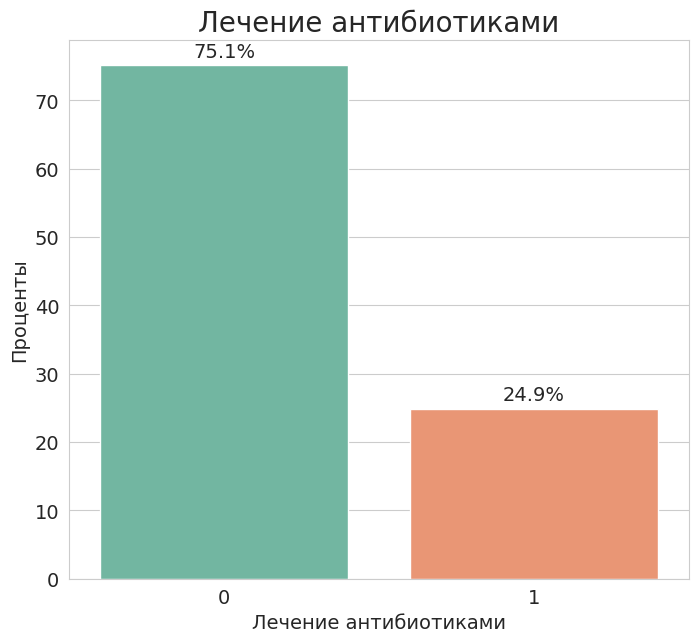

In [87]:
norm_target = (df['ab_indication']
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(8, 7))
ax = sns.barplot(x='index', y='percent', data=norm_target,  palette='Set2')

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                # координата xy
                (p.get_x() + p.get_width() / 2., p.get_height()),
                # центрирование
                ha='center',
                va='center',
                xytext=(0, 10),
                # точка смещения относительно координаты
                textcoords='offset points',
                fontsize=14)

plt.title('Лечение антибиотиками', fontsize=20)
plt.xlabel('Лечение антибиотиками', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

## Correlation map

In [88]:
# cmap = sns.diverging_palette(275,150,  s=40, l=65, n=9)
# corrmat = df.corr()
# plt.subplots(figsize=(18, 18))
# sns.heatmap(corrmat, cmap= cmap, annot=True, square=True);

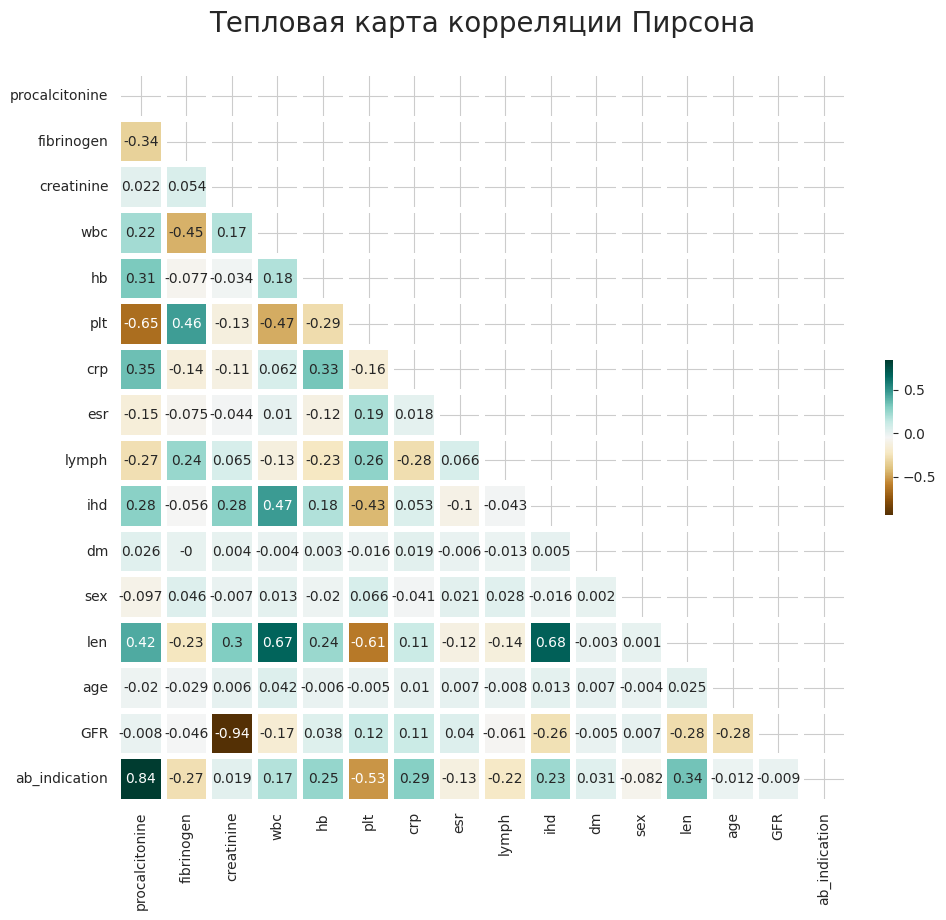

In [89]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 15))
mask = np.triu(np.ones_like(df.corr(numeric_only=True), dtype=bool))

heatmap = sns.heatmap(
    df.corr(numeric_only=True).round(3),
    annot=True,
    square=True,
    cmap="BrBG",
    cbar_kws={"fraction": 0.01},
    linewidth=3,

    mask=mask,
)

heatmap.set_title(
    "Тепловая карта корреляции Пирсона", fontdict={"fontsize": 20}, pad=30
);

**Выводы:**
- уровень прокальцитонина линейно коррелирован с целевой переменной
- также линейную корреляцию имеет уровень тромбоцитов, c-реактивный белок, ЛДГ, и длительность
- некоторые признаки имеют высокую скоррелированность, т.к. будем использовать линейную модель (объяснение выбора модели в modeling), то для построения модели удалим часть признаков, имеющих корреляцию выше 0.9

In [90]:
cor_matrix = df.corr(method='pearson').drop(['ab_indication'], axis=1).corr().abs()

upper_tri = cor_matrix.where(
    np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

to_drop = [
    column for column in upper_tri.columns if any(upper_tri[column] > 0.9)
]
df_clean = df.drop(to_drop, axis=1)

## procalcitonine

<Figure size 640x800 with 0 Axes>

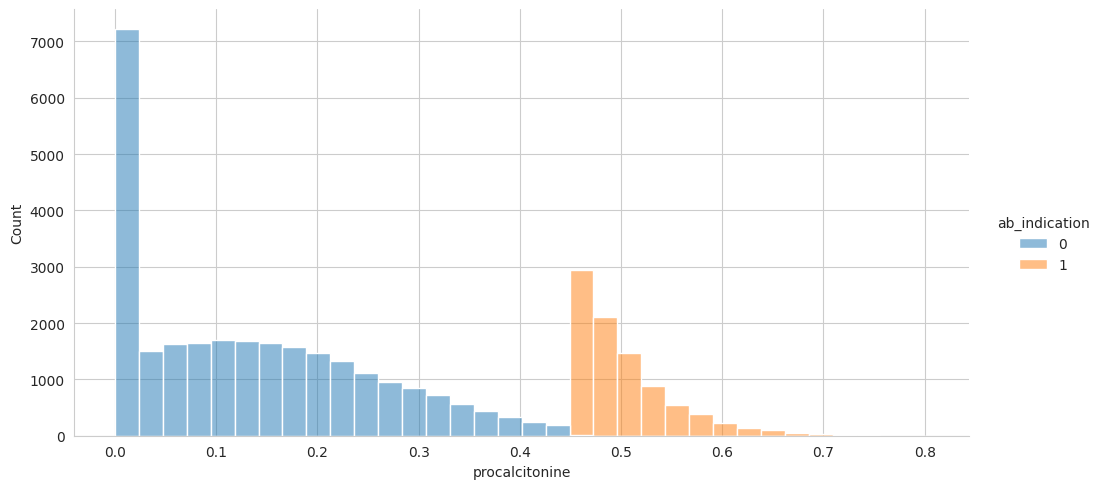

In [91]:
fig = plt.figure(figsize=(8, 10), dpi=80)

sns.displot(data=df,
            x=df['procalcitonine'],
            hue='ab_indication',
            aspect=2)

**Выводы:**
- не совсем ясны наличие явных мод в прокальцитонине
- и явно видна взаимосвязь с назначением лечения от значения 0.45

## age

<Axes: xlabel='age'>

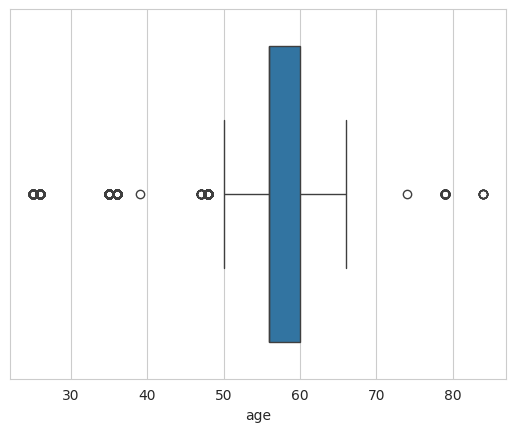

In [92]:
sns.boxplot(df['age'], orient='h')

<Figure size 640x800 with 0 Axes>

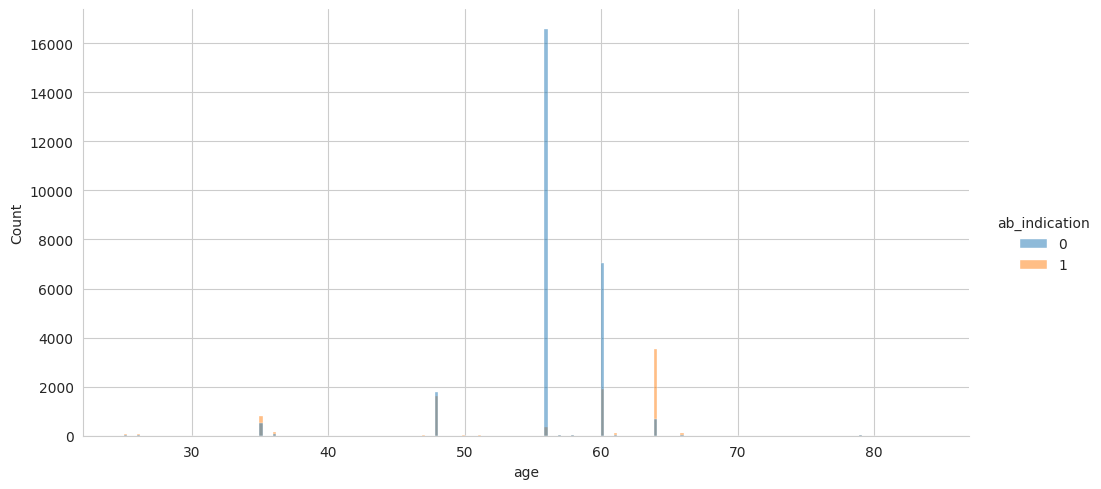

In [93]:
fig = plt.figure(figsize=(8, 10), dpi=80)

sns.displot(data=df,
            x=df['age'],
            hue='ab_indication',
            aspect=2)

**Выводы:**
- у нас очень много выбросов по возрастам, большинство пациентов имели возраст от 55 до 60
- из интересного: лечение пациетом больше 60 назначалось практически всегда

## CRP

<Figure size 640x800 with 0 Axes>

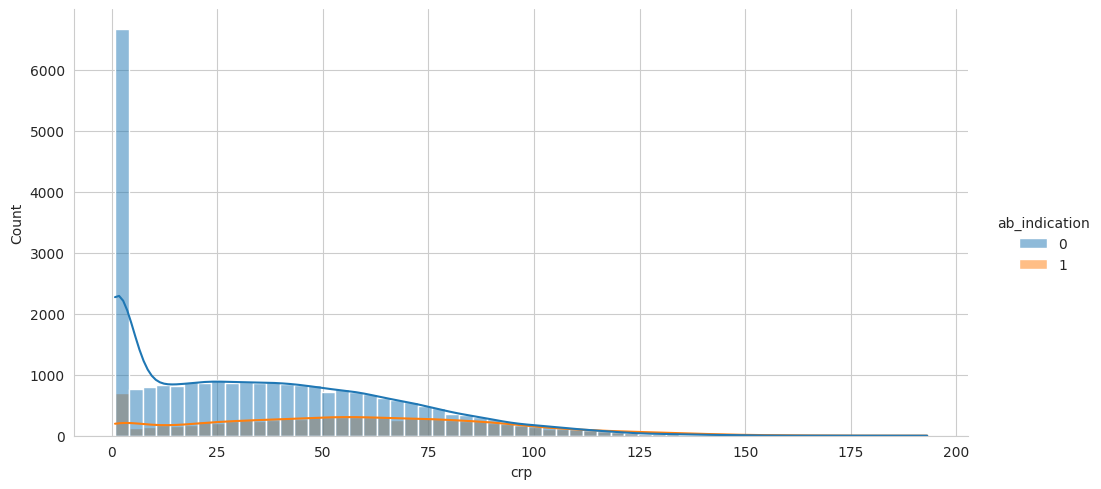

In [94]:
fig = plt.figure(figsize=(8, 10), dpi=80)

sns.displot(data=df,
            x=df['crp'],
            hue='ab_indication',
            kde=True,
            aspect=2)

## sex

In [95]:
def barplot_group(df_data: pd.DataFrame, col_main: str, col_group: str,
                  title: str) -> None:
    """
    Построение barplot с нормированными данными с выводом значений на графике
    """

    plt.figure(figsize=(15, 6))

    data = (df_data.groupby(
        [col_group])[col_main].value_counts(normalize=True).rename(
            'percentage').mul(100).reset_index().sort_values(col_group))

    ax = sns.barplot(x=col_main,
                     y="percentage",
                     hue=col_group,
                     data=data,
                     palette='rocket')

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
            ha='center',  # центрирование
            va='center',
            xytext=(0, 7),
            textcoords='offset points',  # точка смещения относительно координаты
            fontsize=12)

    plt.title(title, fontsize=16)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel(col_main, fontsize=14)
    plt.show()

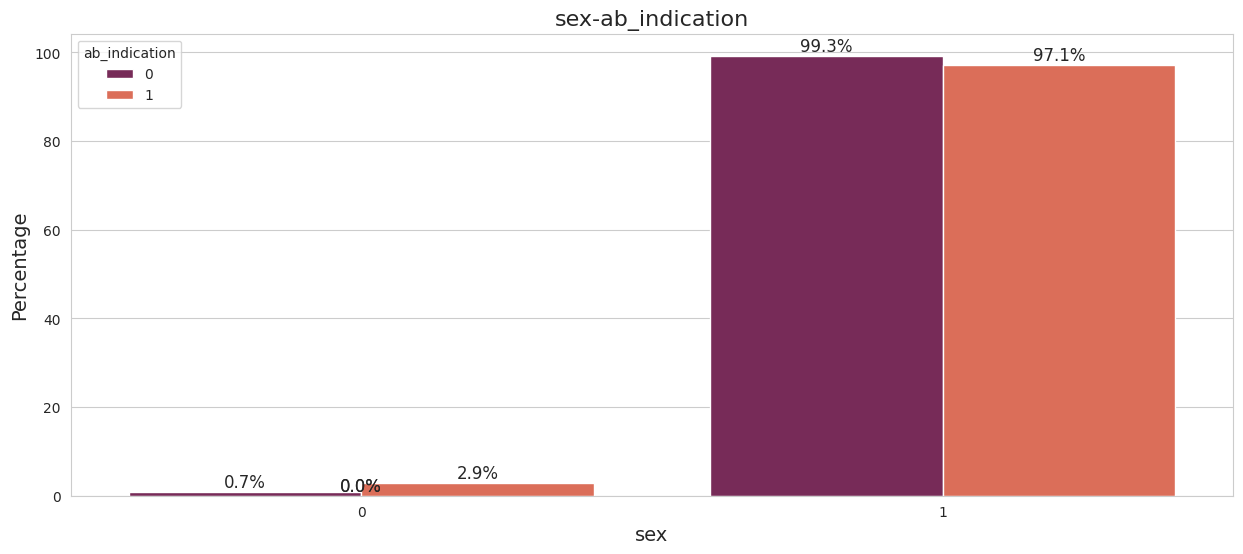

In [96]:
barplot_group(df, "sex", "ab_indication", 'sex-ab_indication')

In [97]:
df['sex'].value_counts()

1    35226
0      454
Name: sex, dtype: int64

**Выводы:**
- одного пола у нас в данных представлено значительно больше, чем другого.

**Выводы**
- вообще при рассмотрении данных они выглядят неинтуитивно понятными, возможно из-за их синтетического характера. Отсюда возможная неиформативность EDA
- насколько понимаю, лучше изначально выдвигать гипотезу о влиянии признака на целевую переменную, а лишь затем проверять и рассматривать данные, исходя из предоположений, но это несколько сложно, т.к. у меня нет мед. образования + возможно данные не слишком репрезентативны
Поэтому предполагаю, что разбирать каждый признак - нецелесообразно.

# Modeling

In [98]:
def get_metrics(y_test, y_pred, y_score, name):

    '''
    Функция для получения метрик модели.
    '''
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    # Основные метрики для задачи классификации
    df_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    df_metrics['ROC_AUC'] = roc_auc_score(y_test, y_score[:, 1])
    df_metrics['Precision'] = precision_score(y_test, y_pred)
    df_metrics['Recall'] = recall_score(y_test, y_pred)
    df_metrics['f1'] = f1_score(y_test, y_pred)
    df_metrics['Logloss'] = log_loss(y_test, y_score)

    return df_metrics

## Baseline

In [99]:
targets = ['ab_indication']

# делим данные на признаки и целевую переменную
X = df_clean.drop(targets, axis=1)
y = df_clean['ab_indication']

In [100]:
# разбиваем данные
# константу инициализировали в начале ноутбука
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=RAND,
                                                    # stratify=y
                                                    )

Возможно лучше было бы использовать, например, бустинги, но в качестве учебной задачи рассмотрим логистическую регрессию.

Предположим мы хотим сразу увидеть вероятность, без дополнительной калибровки, после получения результата, поэтому выбираем логистическую регрессию.

Не будем использовать стратификацию данных и балансировку по классам, т.к. это нарушит нам вероятностный характер ответов модели.

In [101]:
# обучаем Logistic Regression

lg_pipe = Pipeline([('scaler', StandardScaler()),
                    ("lg", LogisticRegression(random_state=RAND,
                          #  class_weight='balanced'
                           ))])

lg_pipe.fit(X_train, y_train)

# получаем спрогнозированные метки классов
y_pred = lg_pipe.predict(X_test)
# получаем спрогнозированные вероятности
y_prob = lg_pipe.predict_proba(X_test)

In [102]:
metrics_cl = get_metrics(y_test, y_pred, y_prob, name='LogisticRegression_Baseline_Test')
metrics_cl

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LogisticRegression_Baseline_Test,0.995067,0.99999,0.980269,1.0,0.990036,0.013273


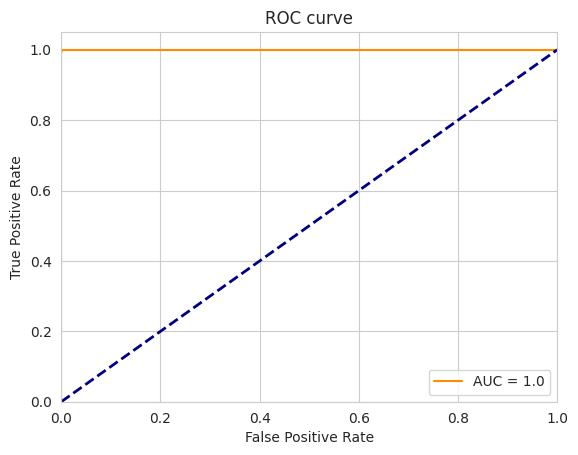

In [103]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])

# auc - Compute Area Under the Curve
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)}')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# масштаб
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

# где расположена легенда
plt.legend(loc="lower right")
plt.show()

## Holdout

Получим значения на кросс-валидации. Разбиваем на 3 фолда X_train, на каждом разбиении получаем значения на валидационной выборке, а также на X_test, которая в данном случае будем holdout выборкой.

In [104]:
finish_test_preds = []
finish_test_preds_proba = []

skf = StratifiedKFold(n_splits=3, random_state=RAND, shuffle=True)
cv_predicts_val = np.empty(3)

for fold, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train)):
    X_train_skf, X_val_skf = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_skf, y_val_skf = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model = Pipeline([('scaler', StandardScaler()),
                      ("lg", LogisticRegression(random_state=RAND,
                          #  class_weight='balanced'
                           ))])
    model.fit(X_train_skf, y_train_skf)

    # OOF
    preds_val_proba = model.predict_proba(X_val_skf)[:, 1]
    cv_predicts_val[fold] = roc_auc_score(y_val_skf, preds_val_proba)

    # holdout
    preds_test = model.predict(X_test)
    preds_test_proba = model.predict_proba(X_test)

    finish_test_preds.append(preds_test)
    finish_test_preds_proba.append(preds_test_proba)

    print(f'На фолде {fold} на валидационной выборке получили значение  '
          f'roc_auc_score = \033[1m{cv_predicts_val[fold]}\033[0m')


print('-' * 60)

print(f'Среднее значение roc_auc_score по трём фолдам '
      f'на валидационной выборке \033[1m{round(np.mean(cv_predicts_val), 5)}\033[0m')

На фолде 0 на валидационной выборке получили значение  roc_auc_score = 0.9999955076487644
На фолде 1 на валидационной выборке получили значение  roc_auc_score = 0.9999990612997418
На фолде 2 на валидационной выборке получили значение  roc_auc_score = 0.9999815612449284
------------------------------------------------------------
Среднее значение roc_auc_score по трём фолдам на валидационной выборке 0.99999


In [105]:
# находим моду по классам
test_pred = stats.mode(np.column_stack(finish_test_preds), axis=1)[0]
# находим среднее по вероятностям
test_pred_proba = np.mean(finish_test_preds_proba, axis=0)

In [106]:
print('ROC-AUC mean OOF: %.3f, std: %.3f' %
      (np.mean(cv_predicts_val), np.std(cv_predicts_val)))
print('ROC-AUC HOLDOUT: %.3f' % roc_auc_score(y_test, test_pred_proba[:,1]))

ROC-AUC mean OOF: 1.000, std: 0.000
ROC-AUC HOLDOUT: 1.000


In [107]:
metrics_cl = pd.concat([
    metrics_cl,
    get_metrics(y_test,
                test_pred,
                test_pred_proba,
                name='LogisticRegression_StratifiedKFold')
])

In [108]:
metrics_cl.set_index('model', inplace=True)
metrics_cl

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
LogisticRegression_Baseline_Test,0.995067,0.999990,0.980269,1.0,0.990036,0.013273
LogisticRegression_StratifiedKFold,0.994058,0.999988,0.976329,1.0,0.988023,0.015170


In [109]:
highlighted_metrics = metrics_cl[['ROC_AUC']].style.highlight_max()
highlighted_metrics

,ROC_AUC
model,
LogisticRegression_Baseline_Test,0.999990
LogisticRegression_StratifiedKFold,0.999988


**Выводы:**
- сложно делать какие-то выводы, т.к. модель практически идеально прогнозирует назначение курса лечения антибиотиками по метрике roc-auc
- впрочем и другие метрики также предсказаны отлично
- вероятно слишком учебная задача